In [46]:
#CIFAR-10 datset

import tensorflow as tf
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, accuracy_score, plot_confusion_matrix

import missingno as msno
import plotly_express as px
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras import datasets, layers, models




#defining dataset
(X,y), (x_test, y_test) =datasets.cifar10.load_data()
assert X.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y.shape == (50000, 1)
assert y_test.shape == (10000, 1)


#convert y to categorical
Y = to_categorical(y)
#shuffler
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


X,Y=unison_shuffled_copies(X, Y)

#split X,Y into four parts
p=len(X)/4
X1=X[:int(p)]
X2=X[int(p):int(2*p)]
X3=X[int(2*p):int(3*p)]
X4=X[int(3*p):]
Y1=Y[:int(p)]
Y2=Y[int(p):int(2*p)]
Y3=Y[int(2*p):int(3*p)]
Y4=Y[int(3*p):]


epochy=100

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_59 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 64)        18496     
                                                      

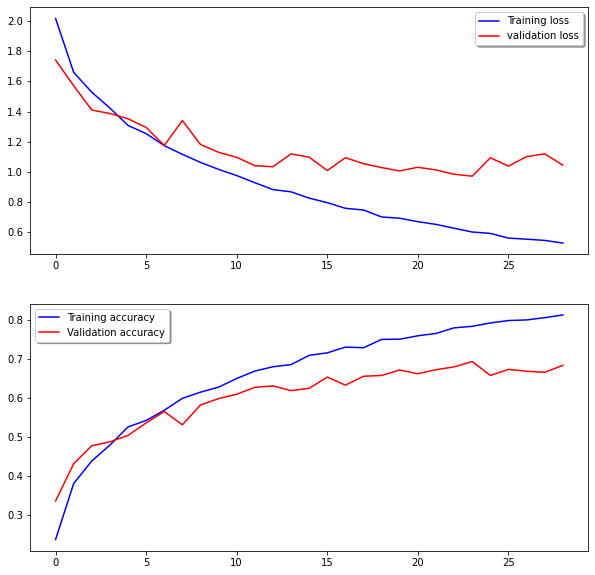

In [47]:
#Train the shadow network using the shadow in set
input_shape=X.shape[1:]
output_shape=Y.shape[1]
#-----------------------------------------------
# a 3-block vgg style architecture
shadow_model = Sequential()
#add rescaling layer
shadow_model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
shadow_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
shadow_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
shadow_model.add(MaxPooling2D((2, 2)))
# shadow_model.add(BatchNormalization())
shadow_model.add(Dropout(0.4))
shadow_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
shadow_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
shadow_model.add(MaxPooling2D((2, 2)))
# shadow_model.add(BatchNormalization())
shadow_model.add(Dropout(0.4))
shadow_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
shadow_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
shadow_model.add(MaxPooling2D((2, 2)))
# shadow_model.add(BatchNormalization())
shadow_model.add(Dropout(0.4))
shadow_model.add(Flatten())
shadow_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
shadow_model.add(Dense(output_shape, activation='softmax'))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
shadow_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss="categorical_crossentropy",metrics=['acc'])
shadow_model.summary()


history_shadow = shadow_model.fit(
    X1, Y1, batch_size=32, epochs=epochy,validation_split=0.2,verbose=0,callbacks=[callback]
)
#Plot the loss and accuracy curves for training and validation

fig, ax = plt.subplots(2,1)
#adjust size
fig.set_size_inches(10, 10)
ax[0].plot(history_shadow.history['loss'], color='b', label="Training loss")
ax[0].plot(history_shadow.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_shadow.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_shadow.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

391/391 [==============================] - 2s 5ms/step
Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 100, 1)]     0           []                               
                                                                                                  
 layer_normalization_30 (LayerN  (None, 100, 1)      2           ['input_16[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_15 (Multi  (None, 100, 1)      28673       ['layer_normalization_30[0][0]', 
 HeadAttention)                                                   'layer_normalization_30[0][0]'] 
                                    

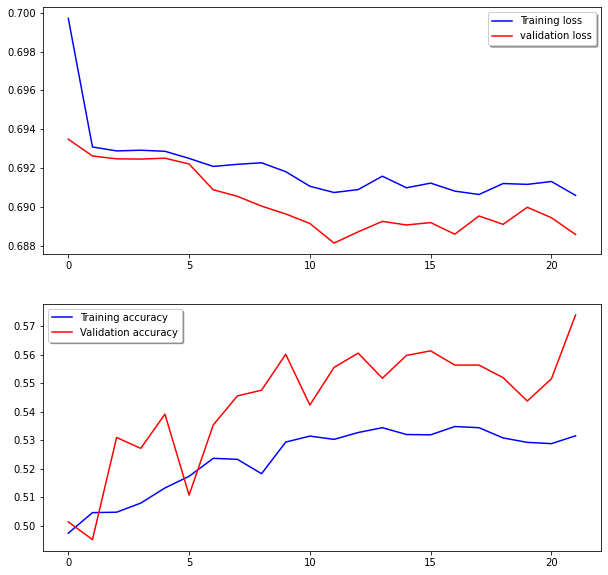

In [48]:
#Train the attack network using the outputs of the shadow in and shadow out set when sent through the shadow network.
#X1,Y1--->shadow in
#X2,Y2--->shadow out
# I see that whole success of this attack is reliant on generalizability of attack network,
#  since current training is independent of testing of target model

shadow_Y1=shadow_model.predict(X1)
shadow_Y2=shadow_model.predict(X2)
bin_Y1=np.ones((len(shadow_Y1),1))
bin_Y2=np.zeros((len(shadow_Y2),1))
#vstack shadow_Y1 and shadow_Y2
shadow_Y=np.vstack((shadow_Y1,shadow_Y2))
#vstack bin_Y1 and bin_Y2
bin_Y=np.vstack((bin_Y1,bin_Y2))

#shuffle shadow_Y and bin_Y
shadow_Y,bin_Y=unison_shuffled_copies(shadow_Y, bin_Y)
shadow_Y=np.expand_dims(shadow_Y, axis=-1)

#spline interpolation
dil_fact=10
omega=1
A=0.1
from scipy import interpolate
shadow_Y_inter=np.zeros((shadow_Y.shape[0],shadow_Y.shape[1]*dil_fact,shadow_Y.shape[2]))
for i in range(shadow_Y.shape[0]):
    for j in range(shadow_Y.shape[2]):
        signal=shadow_Y[i,:,j]
        time=np.linspace(0, len(signal), num=len(signal), endpoint=True)
        time_new = np.linspace(0, len(signal), num=dil_fact*len(signal), endpoint=True)
        f = interpolate.interp1d(time, signal, kind='cubic')
        sn=f(time_new)
        shadow_Y_inter[i,:,j]=sn+A*np.cos(omega*2*np.pi*sn/np.max(sn))
        # shadow_Y_inter[i,:,j]=sn



#---------------------------------------------------------------------------------

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


input_shape = shadow_Y_inter.shape[1:]
attack_model = build_model(
    input_shape,
    head_size=256,
    num_heads=16,
    ff_dim=16,
    num_transformer_blocks=1,
    mlp_units=[10],
    mlp_dropout=0.2,
    dropout=0.1,
)

#---------------------------------------------------------------------------------
EPOCHS=epochy
LEARNING_RATE=1e-3
BATCH_SIZE=4
WEIGHT_DECAY=1e-4

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(X3) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
attack_model.compile(optimizer=tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY),loss="binary_crossentropy",metrics=['acc'])
attack_model.summary()
history_attack = attack_model.fit(
    shadow_Y_inter, bin_Y, batch_size=4, epochs=epochy,validation_split=0.2,callbacks=[callback],verbose=0
)

#Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 10)
ax[0].plot(history_attack.history['loss'], color='b', label="Training loss")
ax[0].plot(history_attack.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_attack.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_attack.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

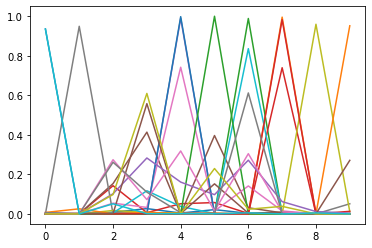

In [49]:
#Raw Probability vectors
for i in range(20):
    plt.plot(shadow_Y[i])

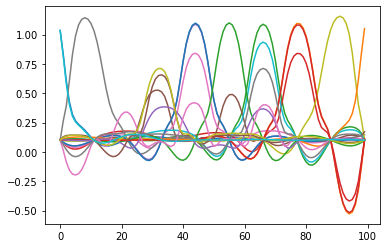

In [50]:
# Transformed Probaility vectors
for i in range(20):
    plt.plot(shadow_Y_inter[i])

In [51]:
# an experiment to see if a raw proability vector can be legimately transformed into a 2-D vector with high standard deviation
vec=shadow_Y[0]
#create a random probability matrix of size a x b
trials=1000
std_list=[]
for i in range(trials):
    a=2
    b=len(vec)
    mat=np.random.rand(a,b)
    #mat multiplied with vec
    vec2=mat.dot(vec)
    #standard deviation of vec2
    std=np.std(vec2)
    std_list.append(std)

#find the minimum standard deviation
print("Maximum Std when considered raw probability vector: ",max(std_list))

Maximum Std when considered raw probability vector:  0.44632742932029656


In [52]:
# an experiment to see if a transformed proability vector can be legimately transformed into a 2-D vector with high standard deviation
vec=shadow_Y_inter[0]

trials=1000
std_list=[]
for i in range(trials):
    a=2
    b=len(vec)
    mat=np.random.rand(a,b)
    #mat multiplied with vec
    vec2=mat.dot(vec)
    #standard deviation of vec2
    std=np.std(vec2)
    std_list.append(std)

#find the minimum standard deviation
print("Maximum Std when considered transformed probability vector: ",max(std_list))

Maximum Std when considered transformed probability vector:  1.2505986629331147


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_65 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_38 (Conv2D)          (None, 16, 16, 64)        18496     
                                                      

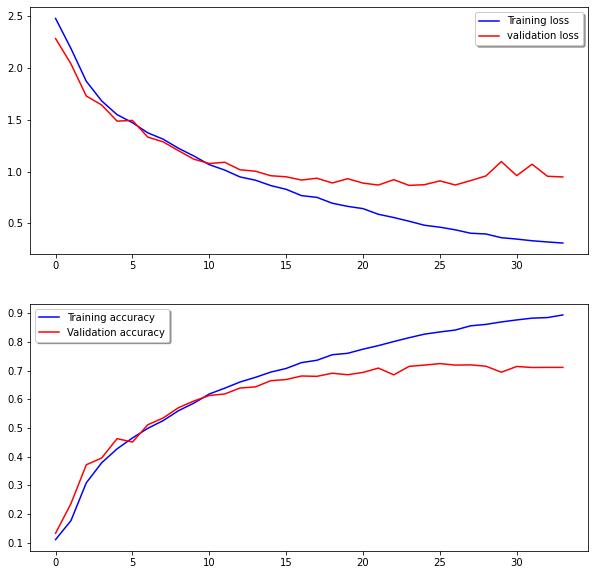

In [53]:
#Train the target network using the target in set
#X3,Y3--->target in
import tensorflow_addons as tfa
input_shape=X.shape[1:]
output_shape=Y.shape[1]
#---------------------------------------------------------------------------------
# a 3-block vgg style architecture
target_model = Sequential()
#add rescaling layer
target_model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape))
target_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(MaxPooling2D((2, 2)))
# shadow_model.add(BatchNormalization())
target_model.add(Dropout(0.2))
target_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(MaxPooling2D((2, 2)))
# shadow_model.add(BatchNormalization())
target_model.add(Dropout(0.3))
target_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
target_model.add(MaxPooling2D((2, 2)))
# shadow_model.add(BatchNormalization())
target_model.add(Dropout(0.4))
target_model.add(Flatten())
target_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform',name="getter"))
target_model.add(Dense(output_shape, activation='softmax'))

#---------------------------------------------------------------------------------

EPOCHS=epochy
LEARNING_RATE=1e-3
BATCH_SIZE=32
WEIGHT_DECAY=1e-4

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(X3) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
target_model.compile(optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY),loss="categorical_crossentropy",metrics=['acc'])
target_model.summary()
history_target = target_model.fit(
    X3, Y3, batch_size=32, epochs=epochy,validation_split=0.2,verbose=0,callbacks=[callback]
)

#Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 10)
ax[0].plot(history_target.history['loss'], color='b', label="Training loss")
ax[0].plot(history_target.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_target.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_target.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

782/782 [==============================] - 5s 6ms/step
-------------------------------------------------------------------
Accuracy: 0.54544
Precision: 0.5604578961844255
Recall: 0.79464
F1 score: 0.63611911623439


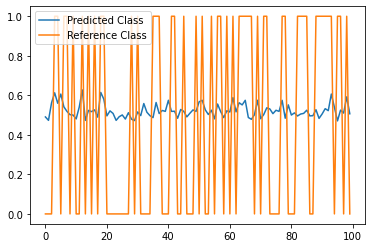

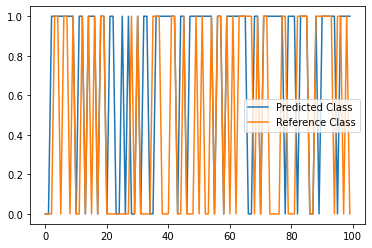

In [54]:
#Test the attack network using the outputs of the target in and target out set when sent through the target network.
#X3,Y3--->target in
#X4,Y4--->target out

target_Y3=target_model.predict(X3)
target_Y4=target_model.predict(X4)
bin_Y3=np.ones((len(target_Y3),1))
bin_Y4=np.zeros((len(target_Y4),1))
#vstack target_Y3 and target_Y4
target_Y=np.vstack((target_Y3,target_Y4))
#vstack bin_Y3 and bin_Y4
bin2_Y=np.vstack((bin_Y3,bin_Y4))

#shuffle target_Y and bin2_Y
target_Y,bin2_Y=unison_shuffled_copies(target_Y, bin2_Y)
target_Y=np.expand_dims(target_Y, axis=-1)

#spline interpolation

omega=1
A=0.1
from scipy import interpolate
target_Y_inter=np.zeros((target_Y.shape[0],target_Y.shape[1]*dil_fact,target_Y.shape[2]))
for i in range(target_Y.shape[0]):
    for j in range(target_Y.shape[2]):
        signal=target_Y[i,:,j]
        time=np.linspace(0, len(signal), num=len(signal), endpoint=True)
        time_new = np.linspace(0, len(signal), num=dil_fact*len(signal), endpoint=True)
        f = interpolate.interp1d(time, signal, kind='cubic')
        sn=f(time_new)
        target_Y_inter[i,:,j]=sn+A*np.sin(omega*2*np.pi*sn/np.max(sn))
        # shadow_Y_inter[i,:,j]=sn

bin2_Y_pred=attack_model.predict(target_Y_inter)

#binarize bin2_Y_pred
bin2_Y_pred_star=np.copy(bin2_Y_pred)
bin2_Y_pred=np.where(bin2_Y_pred>0.5,1,0)
print("-------------------------------------------------------------------")
#calculate the accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:",round(accuracy_score(bin2_Y, bin2_Y_pred),10))
#calculate the precision
from sklearn.metrics import precision_score
print("Precision:",precision_score(bin2_Y.astype(int), bin2_Y_pred.astype(int),average='macro'))
#calculate the recall
from sklearn.metrics import recall_score
print("Recall:",recall_score(bin2_Y, bin2_Y_pred))
#calculate the f1 score
from sklearn.metrics import f1_score
print("F1 score:",f1_score(bin2_Y, bin2_Y_pred))    


#plot bin2_Y_pred and bin2_Y
till=100
plt.figure()
plt.plot(bin2_Y_pred_star[:till])
plt.plot(bin2_Y[:till])
plt.legend(['Predicted Class','Reference Class'])
plt.show()

plt.figure()
plt.plot(bin2_Y_pred[:till])
plt.plot(bin2_Y[:till])
plt.legend(['Predicted Class','Reference Class'])
plt.show()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6_input (InputLay  [(None, 32, 32, 3)]      0         
 er)                                                             
                                                                 
 rescaling_6 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_65 (Dropout)        (None, 16, 16, 32)        0  

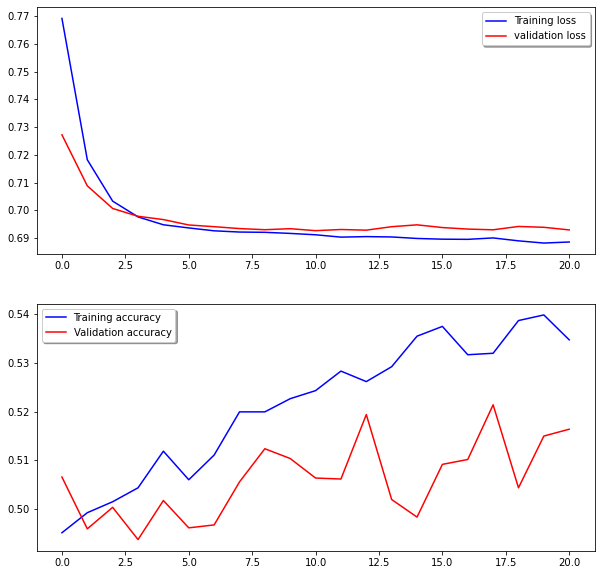

In [55]:
from keras.models import Model
target_model.trainable=False
layer_name = 'getter'
x = layers.Dense(10, activation="tanh")(target_model.get_layer(layer_name).output)
o=layers.Dense(1, activation="sigmoid")(x)
mollified_target_model= Model(inputs=target_model.input, outputs=[o])

see_X3=X3
see_X4=X4
bin_Y3=np.ones((len(see_X3),1))
bin_Y4=np.zeros((len(see_X4),1))
#vstack see_X3 and see_X4
see_X=np.vstack((see_X3,see_X4))
#vstack bin_Y3 and bin_Y4
bin2_Y=np.vstack((bin_Y3,bin_Y4))
#shuffle see_X and bin2_Y
see_X,bin2_Y=unison_shuffled_copies(see_X, bin2_Y)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mollified_target_model.compile(optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY),loss="binary_crossentropy",metrics=['acc'])
mollified_target_model.summary()
history_target_mol = mollified_target_model.fit(
    see_X, bin2_Y, batch_size=32, epochs=epochy,validation_split=0.2,verbose=0,callbacks=[callback]
)
#Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 10)
ax[0].plot(history_target_mol.history['loss'], color='b', label="Training loss")
ax[0].plot(history_target_mol.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_target_mol.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history_target_mol.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)



bin2_Y_pred_mollified=mollified_target_model.predict(see_X)
#binarize bin2_Y_pred_mollified
bin2_Y_pred_mollified_star=np.copy(bin2_Y_pred_mollified)
bin2_Y_pred_mollified_star=np.where(bin2_Y_pred_mollified_star>0.5,1,0)


#calculate the accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:",round(accuracy_score(bin2_Y, bin2_Y_pred_mollified_star),10))
#calculate the precision
from sklearn.metrics import precision_score
print("Precision:",precision_score(bin2_Y, bin2_Y_pred_mollified_star))
#calculate the recall
from sklearn.metrics import recall_score
print("Recall:",recall_score(bin2_Y, bin2_Y_pred_mollified_star))
#calculate the f1 score
from sklearn.metrics import f1_score
print("F1 score:",f1_score(bin2_Y, bin2_Y_pred_mollified_star))